### well structured - an ode to databases


# data preparation

### import libraries

In [1]:
# access libaries
import yfinance as yf
import sqlite3

# scientific computing pandas (data structures & tools), NumPy (array & tools), SciPy (Integrals, solving differential equations, optimization)
import pandas as pd
import numpy as np

# Visualization matplotlib (plots & graphs, most popular), seaborn (plots: heat maps, time series, violin plots)
import matplotlib.pyplot as plt
%matplotlib inline

### build stock preparation class

In [2]:
class stock_prep:
    def __init__(self, ticker_symbol):
       
        # load data
        self.ticker_symbol = ticker_symbol
        self.company_name = yf.Ticker(self.ticker_symbol).info['longName'].replace(r'/', ' ')
        self.currency = yf.Ticker(self.ticker_symbol).info['currency']


        # return dfs
        self.company_stock_prices = []
        self.trim_company_stock_price = []
        self.replace_company_stock_prices = []
        self.missing_company_stock_prices = []
        self.avg_norm_loss_company_stock_prices = []
        self.formatted_date_to_index = []
        self.standardization_company_stock_prices = []
        self.normalization_company_stock_prices = []
        self.binning_company_stock_prices = []
        self.indicator_variables_stock_prices = []
        self.to_sql_stock_prices = []

    # ------------------------ DATABASE -----------------------------------------
        
    def to_sqlite_database(self, db_name):

        conn = sqlite3.connect(db_name)
        self.to_sql_stock_prices.to_sql(name=self.company_name, con=conn, if_exists='replace')
        conn.commit()
        conn.close() 

    def read_sqlite_database(self, ticker_symbol, db_name, columns):
               
        company_name = yf.Ticker(ticker_symbol).info['longName'].replace(r'/', ' ')
        conn = sqlite3.connect(db_name)
        sql = "SELECT " + columns + " FROM `" + company_name + "`"
        result = pd.read_sql(sql,conn)
        return result
       
    # ------------------------ DATA ----------------------------------------- 
    
    def replace_values(self):
        self.company_stock_prices = self.read_sqlite_database(self.ticker_symbol, 'stocks_prep.db', 'date, `close_trim_' + self.ticker_symbol + '`')
        self.replace_company_stock_prices = self.company_stock_prices.replace("Null", np.nan)
        
    def missing_values_count(self):

        # count missing values
        self.missing_company_stock_prices = self.replace_company_stock_prices.isnull()
        self.missing_company_stock_prices = self.missing_company_stock_prices['close_trim_' + self.ticker_symbol].value_counts()
            
    def avg_norm_loss(self):

        # calculate mean and replace missing values
        aux_var_avg_norm_loss = self.replace_company_stock_prices['close_trim_' + self.ticker_symbol].astype("float").mean(axis=0)
        self.avg_norm_loss_company_stock_prices = self.replace_company_stock_prices['close_trim_' + self.ticker_symbol].replace(np.nan, aux_var_avg_norm_loss)

        # rename Series for df
        first_item = self.replace_company_stock_prices['date'] 
        second_item = self.avg_norm_loss_company_stock_prices 

        # build df
        self.avg_norm_loss_company_stock_prices = pd.concat([first_item, second_item], axis=1) 
        
    def standardization(self):
        
        aux_var_euro_dollar = self.read_sqlite_database('EURUSD=X', 'stocks_prep.db', 'date, `close_trim_EURUSD=X`')
        
        # standardize close_avg_norm_loss
        aux_var_form_ind = self.avg_norm_loss_company_stock_prices['close_trim_' + self.ticker_symbol]/aux_var_euro_dollar['close_trim_EURUSD=X']
    
        # rename Series for df
        first_item = self.avg_norm_loss_company_stock_prices
        second_item =  aux_var_form_ind.rename("close_stand_" + self.ticker_symbol)

        # build df        
        self.standardization_company_stock_prices = pd.concat([first_item, second_item], axis=1)
        
    def normalization(self):

        # replace (original value) by (original value)/(maximum value)
        aux_var_norm_close = self.standardization_company_stock_prices['close_stand_' + self.ticker_symbol]/self.standardization_company_stock_prices['close_stand_' + self.ticker_symbol].max()

        # rename Series for df
        first_item = self.standardization_company_stock_prices
        second_item = aux_var_norm_close.rename("close_normal_" + self.ticker_symbol)

        # build df
        self.normalization_company_stock_prices = pd.concat([first_item, second_item], axis=1)
        
    def binning(self):

        # build bins
        aux_var_bins = np.linspace(min(self.normalization_company_stock_prices["close_normal_"  + self.ticker_symbol]), max(self.normalization_company_stock_prices["close_normal_" + self.ticker_symbol]), 4)
        aux_var_group_names = ["Low", "Medium", "High"]
        aux_var_build_bins = pd.cut(self.normalization_company_stock_prices['close_normal_' + self.ticker_symbol], aux_var_bins, labels = aux_var_group_names, include_lowest= True)
        
        # rename Series for df
        first_item = self.normalization_company_stock_prices
        second_item = aux_var_build_bins.rename("close_binned_" + self.ticker_symbol)

        # build df
        self.binning_company_stock_prices = pd.concat([first_item, second_item], axis=1)

    def indicator_variables(self):

        # build indicators
        aux_var_indi = pd.get_dummies(self.binning_company_stock_prices["close_binned_" + self.ticker_symbol])
        aux_var_drop = self.binning_company_stock_prices.drop(['close_binned_' + self.ticker_symbol], axis = 1)

        # rename Series for df
        first_item = aux_var_drop
        second_item = aux_var_indi #.rename(columns={'Medium':'close_price_medium', 'High':'close_price_high'}, inplace=True)

        # # build df
        self.indicator_variables_stock_prices = pd.concat([first_item, second_item], axis=1)

    def trim_same_length(self, ticker_symbols):
        
        # load data
        first_aux_var_corr = self.read_sqlite_database(self.ticker_symbol, 'stocks_orig.db', 'Date, Close')
        
        # rename Series for df
        first_item = first_aux_var_corr.rename(columns={"Date" : "date", "Close": "close_trim_" + self.ticker_symbol})
        
        for ticker_symbol in ticker_symbols:

            # load data
            second_aux_var_corr = self.read_sqlite_database(ticker_symbol, 'stocks_orig.db', 'Date, Close') 

            # rename Series for df
            second_item = second_aux_var_corr.rename(columns={"Date" : "date", "Close": "close_trim_" + ticker_symbol})

            # build df
            first_item = pd.merge(first_item, second_item, how = "outer", on = ['date', 'date'])

        # load data
        second_item = self.read_sqlite_database('EURUSD=X', 'stocks_orig.db', 'Date, Close')
        
        # rename Series for df
        second_item = second_item.rename(columns={"Date" : "date", "Close": "close_trim_EURUSD=X"})

        self.trim_company_stock_price = pd.merge(first_item, second_item, how = "left", on = ['date', 'date'])

        self.trim_company_stock_price

    # ------------------------ VISUALISATION -----------------------------------------

    def plot_bins_hist(self):
        
        plt.hist(self.binning_company_stock_prices["close_binned_" + self.ticker_symbol], bins = 3)
       
        plt.xlabel("amount")
        plt.ylabel("close_binned_" + self.ticker_symbol)
        plt.title("Close_Price_Categories")     
    

    

### trim length

In [3]:
stock_prep_obj = stock_prep('WOOE.AS')
ticker_symbols = ['WY', 'SCA-B.ST' , 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH']

# trim lenght 
stock_prep_obj.trim_same_length(ticker_symbols)
aux_val_company_stock_price = stock_prep_obj.trim_company_stock_price
aux_val_company_stock_price.head() 

,date,close_trim_WOOE.AS,close_trim_WY,close_trim_SCA-B.ST,close_trim_SUZ,close_trim_SK3.IR,close_trim_IP,close_trim_STERV.HE,close_trim_RYN,close_trim_WFG,close_trim_WRK,close_trim_PCH,close_trim_EURUSD=X
0,2021-11-01 00:00:00,NaN,36.980000,138.649994,8.70,45.939999,49.099998,14.50,37.990002,80.120003,47.790001,53.889999,1.155668
1,2021-11-02 00:00:00,NaN,36.150002,135.500000,8.64,45.490002,48.950001,14.31,37.669998,80.250000,47.139999,53.250000,1.159958
2,2021-11-03 00:00:00,NaN,38.270000,137.250000,8.94,45.470001,49.910000,14.51,39.400002,83.269997,48.419998,56.880001,1.157943
3,2021-11-04 00:00:00,NaN,38.139999,134.949997,8.78,45.520000,48.750000,14.36,39.299999,83.349998,47.970001,56.889999,1.161575
4,2021-11-05 00:00:00,30.7094,38.330002,133.550003,8.95,45.070000,48.869999,14.46,38.930000,83.639999,48.759998,56.990002,1.155535


In [4]:
stock_prep_obj.trim_company_stock_price['date'].describe()

count                     624
unique                    624
top       2021-11-01 00:00:00
freq                        1
Name: date, dtype: object

<font color='#5891db'>Using the common date column, all data records can be expanded to a common length of 624.</font>

### store values in database

In [5]:
ticker_symbols = ['WOOE.AS', 'WY', 'SCA-B.ST' , 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH', 'EURUSD=X']
aux_val_company_stock_price

for ticker_symbol in ticker_symbols:
    stock_prep_obj = stock_prep(ticker_symbol)
    stock_prep_obj.to_sql_stock_prices = aux_val_company_stock_price[['date','close_trim_' + ticker_symbol]]
    stock_prep_obj.to_sqlite_database('stocks_prep.db')

### handling missing values

In [6]:
stock_prep_obj = stock_prep('EURUSD=X')

In [7]:
# replace missing values
stock_prep_obj.replace_values()
stock_prep_obj.avg_norm_loss()
print(stock_prep_obj.avg_norm_loss_company_stock_prices.head(5))


                  date  close_trim_EURUSD=X
0  2021-11-01 00:00:00             1.155668
1  2021-11-02 00:00:00             1.159958
2  2021-11-03 00:00:00             1.157943
3  2021-11-04 00:00:00             1.161575
4  2021-11-05 00:00:00             1.155535


<font color='#5891db'>Missing values ​​are replaced with the average value.</font>

In [8]:
stock_prep_obj.to_sql_stock_prices = stock_prep_obj.avg_norm_loss_company_stock_prices
stock_prep_obj.to_sqlite_database('stocks_prep.db')

### identify and handling missing values

In [9]:
stock_prep_obj = stock_prep('WOOE.AS')

In [10]:
# replace missing values
stock_prep_obj.replace_values()
print(stock_prep_obj.replace_company_stock_prices.head(5))

                  date  close_trim_WOOE.AS
0  2021-11-01 00:00:00                 NaN
1  2021-11-02 00:00:00                 NaN
2  2021-11-03 00:00:00                 NaN
3  2021-11-04 00:00:00                 NaN
4  2021-11-05 00:00:00             30.7094


In [11]:
# identify missing values
stock_prep_obj.missing_values_count()
print(stock_prep_obj.missing_company_stock_prices)

close_trim_WOOE.AS
False    609
True      15
Name: count, dtype: int64


In [12]:
# handling missing values
stock_prep_obj.avg_norm_loss()
print(stock_prep_obj.avg_norm_loss_company_stock_prices.head(5))

                  date  close_trim_WOOE.AS
0  2021-11-01 00:00:00           26.670818
1  2021-11-02 00:00:00           26.670818
2  2021-11-03 00:00:00           26.670818
3  2021-11-04 00:00:00           26.670818
4  2021-11-05 00:00:00           30.709400


<font color='#5891db'>Missing values ​​are replaced with the average value.</font>

### data standardization

In [13]:
stock_prep_obj.standardization()
print(stock_prep_obj.standardization_company_stock_prices.head(5))


                  date  close_trim_WOOE.AS  close_stand_WOOE.AS
0  2021-11-01 00:00:00           26.670818            23.078260
1  2021-11-02 00:00:00           26.670818            22.992912
2  2021-11-03 00:00:00           26.670818            23.032918
3  2021-11-04 00:00:00           26.670818            22.960907
4  2021-11-05 00:00:00           30.709400            26.575916


<font color='#5891db'>The price of the shares and the ETF are given in US dollars and are transformed into euros.</font>

### normalization

In [14]:
stock_prep_obj.normalization()
print(stock_prep_obj.normalization_company_stock_prices.head(5))

                  date  close_trim_WOOE.AS  close_stand_WOOE.AS  \
0  2021-11-01 00:00:00           26.670818            23.078260   
1  2021-11-02 00:00:00           26.670818            22.992912   
2  2021-11-03 00:00:00           26.670818            23.032918   
3  2021-11-04 00:00:00           26.670818            22.960907   
4  2021-11-05 00:00:00           30.709400            26.575916   

   close_normal_WOOE.AS  
0              0.780673  
1              0.777786  
2              0.779139  
3              0.776703  
4              0.898989  


<font color='#5891db'>To ensure that all individual stocks have the same influence on the ETF, their values ​​are normalized by simple feature scaling</font>

### binning

                  date  close_trim_WOOE.AS  close_stand_WOOE.AS  \
0  2021-11-01 00:00:00           26.670818            23.078260   
1  2021-11-02 00:00:00           26.670818            22.992912   
2  2021-11-03 00:00:00           26.670818            23.032918   
3  2021-11-04 00:00:00           26.670818            22.960907   
4  2021-11-05 00:00:00           30.709400            26.575916   

   close_normal_WOOE.AS close_binned_WOOE.AS  
0              0.780673                  Low  
1              0.777786                  Low  
2              0.779139                  Low  
3              0.776703                  Low  
4              0.898989                 High  


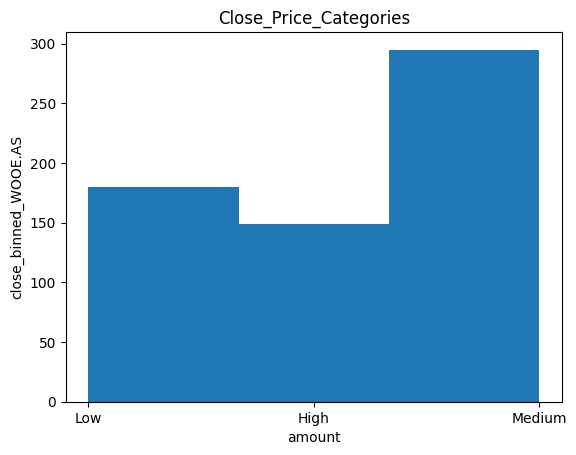

In [15]:
stock_prep_obj.binning()
print(stock_prep_obj.binning_company_stock_prices.head(5))
stock_prep_obj.plot_bins_hist()

<font color='#5891db'>The data is divided into 3 equal number ranges within the price interval. The price category medium contains the most values.</font>

### indicator Variables

In [16]:
stock_prep_obj.indicator_variables()
print(stock_prep_obj.indicator_variables_stock_prices.head(5))

                  date  close_trim_WOOE.AS  close_stand_WOOE.AS  \
0  2021-11-01 00:00:00           26.670818            23.078260   
1  2021-11-02 00:00:00           26.670818            22.992912   
2  2021-11-03 00:00:00           26.670818            23.032918   
3  2021-11-04 00:00:00           26.670818            22.960907   
4  2021-11-05 00:00:00           30.709400            26.575916   

   close_normal_WOOE.AS    Low  Medium   High  
0              0.780673   True   False  False  
1              0.777786   True   False  False  
2              0.779139   True   False  False  
3              0.776703   True   False  False  
4              0.898989  False   False   True  


<font color='#5891db'>The categorical variables are now converted to numerical values, as numbers are commonly used when building a model.</font>

### store in  stock_prep db

In [17]:
stock_prep_obj.to_sql_stock_prices = stock_prep_obj.indicator_variables_stock_prices
stock_prep_obj.to_sqlite_database('stocks_prep.db')

### store data in sqlite db

In [18]:
ticker_symbols = ['WY', 'SCA-B.ST', 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH']
#file_names = os.listdir('data/')
#print(file_names)

for ticker_symbol in ticker_symbols:

    # call init class
    stock_prep_obj = stock_prep(ticker_symbol)

    # replace missing values
    stock_prep_obj.replace_values()
    
    # identify missing values
    stock_prep_obj.missing_values_count()
    
    # handling missing values
    stock_prep_obj.avg_norm_loss()

    # data standardization
    stock_prep_obj.standardization()

    # data normalization
    stock_prep_obj.normalization()

    # binning
    stock_prep_obj.binning()
    # stock_prep_obj.plot_bins()

    # indicator variables
    stock_prep_obj.indicator_variables()

    # data in sqlite database
    stock_prep_obj.to_sql_stock_prices = stock_prep_obj.indicator_variables_stock_prices
    stock_prep_obj.to_sqlite_database('stocks_prep.db')

    print('stored in stocks_prep db: ' + ticker_symbol)

    

stored in stocks_prep db: WY
stored in stocks_prep db: SCA-B.ST
stored in stocks_prep db: SUZ
stored in stocks_prep db: SK3.IR
stored in stocks_prep db: IP
stored in stocks_prep db: STERV.HE
stored in stocks_prep db: RYN
stored in stocks_prep db: WFG
stored in stocks_prep db: WRK
stored in stocks_prep db: PCH


<font color='#5891db'>The data is stored in a second database for the prepared values.</font>